# [NILUT: Conditional Neural Implicit 3D Lookup Tables for Image Enhancement](https://arxiv.org/abs/2306.11920)

### Example of Conditional NILUT for Multi-style encoding and Blending.

<img src="media/header.png" alt="NILUT" width="1000"> 

[Paper link here](https://arxiv.org/abs/2306.11920)

> 3D lookup tables (3D LUTs) are a key component for image enhancement. Modern image signal processors (ISPs) have dedicated support for these as part of the camera rendering pipeline. Cameras typically provide multiple options for picture styles, where each style is usually obtained by applying a unique handcrafted 3D LUT. Current approaches for learning and applying 3D LUTs are notably fast, yet not so memory-efficient, as storing multiple 3D LUTs is required. For this reason and other implementation limitations, their use on mobile devices is less popular.
In this work, we propose a Neural Implicit LUT (NILUT), an implicitly defined continuous 3D color transformation parameterized by a neural network. We show that NILUTs are capable of accurately emulating real 3D LUTs. Moreover, a NILUT can be extended to incorporate multiple styles into a single network with the ability to blend styles implicitly. Our novel approach is memory-efficient, controllable and can complement previous methods, including learned ISPs.

Contact marcos.conde[at]uni-wuerzburg.de

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from glob import glob
from skimage import io, color
from IPython import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print (np.__version__)
print (torch.__version__)
print (torch.cuda.is_available())
print (device)

# Timing utilities
start_time = None

1.24.3
2.0.1
True
cuda:0


In [2]:
# Import utils

from utils import start_timer, end_timer_and_print, clean_mem
from utils import load_img, save_rgb, plot_all, pt_psnr, np_psnr, deltae_dist, count_parameters
from dataloader import EvalMultiLUTBlending

## Define a simple NILUT

The NILUT is inspired in coordinate-based neural networks, also known as implicit neural representations (INRs).
Our main references for this work are:
- [Implicit Neural Representations with Periodic Activation Functions](https://arxiv.org/abs/2006.09661)
- [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/abs/2006.10739)

In [3]:
class NILUT(nn.Module):
    def __init__(self, in_features=3, hidden_features=256, hidden_layers=3, out_features=3, res=False):
        super().__init__()
        
        self.res = res
        self.net = []
        self.net.append(nn.Linear(in_features, hidden_features))
        self.net.append(nn.ReLU())
        
        for _ in range(hidden_layers):
            self.net.append(nn.Linear(hidden_features, hidden_features))
            self.net.append(nn.Tanh())
        
        self.net.append(nn.Linear(hidden_features, out_features))
        if not self.res:
            self.net.append(torch.nn.Sigmoid())
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, intensity):
        output = self.net(intensity)
        if self.res:
            output = output + intensity[:,:3]
            output = torch.clamp(output, 0.,1.)
        
        return output, intensity

## Simple Test: Multi-Style + Blending

We load a simple model `nilutx3style.pt` with 3 styles and a simple blending basis (interpolation of the 3 styles with equal weights). The model was trained during a few minutes on three different 3D LUTs and a blending basis that consists on the average of the three sytles (i.e. each style * 0.333).


- The `input` is the image without processing + the desired `style vector`.
- The `output` is the enhanced image after applying the specific 3D LUT transformation, ot the blending of different styles.

In the example, we use weights `[0.33, 0.33, 0.33]` to simply blend the three 3D LUT styles with the same contribution/weight.
We also provide the PSNR and DeltaE values between the enhanced image and the original reference.

You can find the dataloader `EvalMultiLUTBlending` in `dataloader.py`

In [4]:
PATH = "models/nilutx3style.pt"

In [5]:
lut_model  = NILUT(in_features=3+3, out_features=3, hidden_features=256, hidden_layers=2, res=True)
lut_model.load_state_dict(torch.load(PATH)['model'])
lut_model.cuda()
lut_model.eval()

NILUT(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [6]:
test_images = EvalMultiLUTBlending('./dataset/001.png', 
                                 ['./dataset/001_LUT01.png', 
                                  './dataset/001_LUT03.png', 
                                  './dataset/001_LUT04.png',
                                  './dataset/001_blend.png'], nluts=3)
            
test_dataloader = DataLoader(test_images, batch_size=1, pin_memory=True, num_workers=0)
tsimgsize = test_images.shape

STYLE [1. 0. 0.] PSNR=39.732565893688246, DeltaE=2.34419848532206 --- shape (2000, 3008, 3), min error 0.0, max error 0.002560485852882266


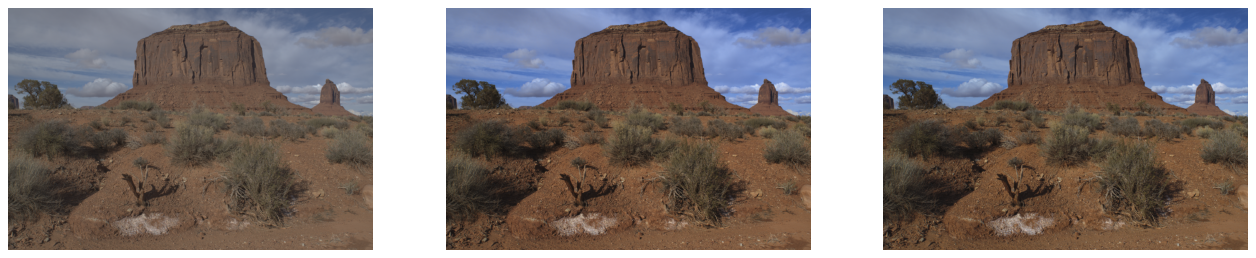

STYLE [0. 1. 0.] PSNR=35.66107539715166, DeltaE=3.5811860789153886 --- shape (2000, 3008, 3), min error 0.0, max error 0.0045629204250872135


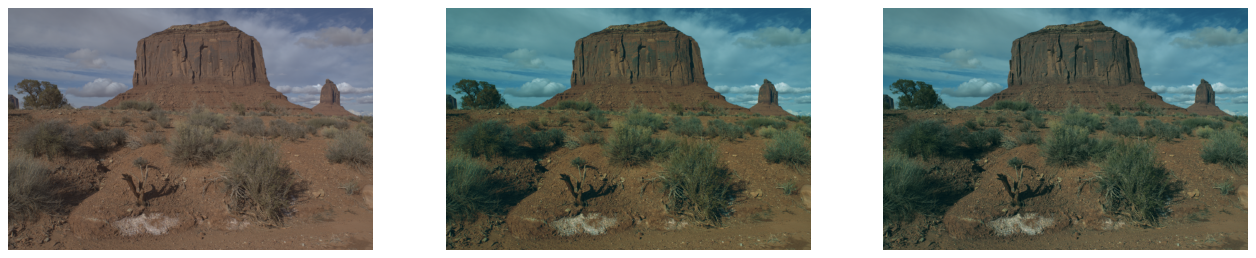

STYLE [0. 0. 1.] PSNR=47.74531432004977, DeltaE=0.9581161106119157 --- shape (2000, 3008, 3), min error 0.0, max error 0.0005754588637501001


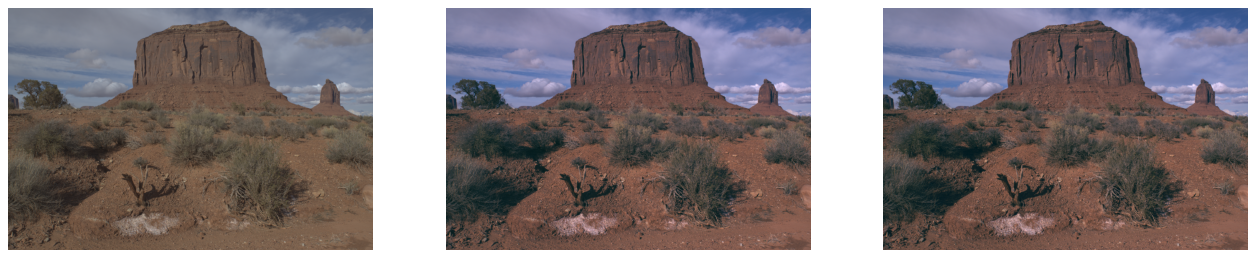

STYLE [0.33 0.33 0.33] PSNR=43.6739587626795, DeltaE=1.3578132051792222 --- shape (2000, 3008, 3), min error 3.552713678800501e-15, max error 0.0014273138949647546


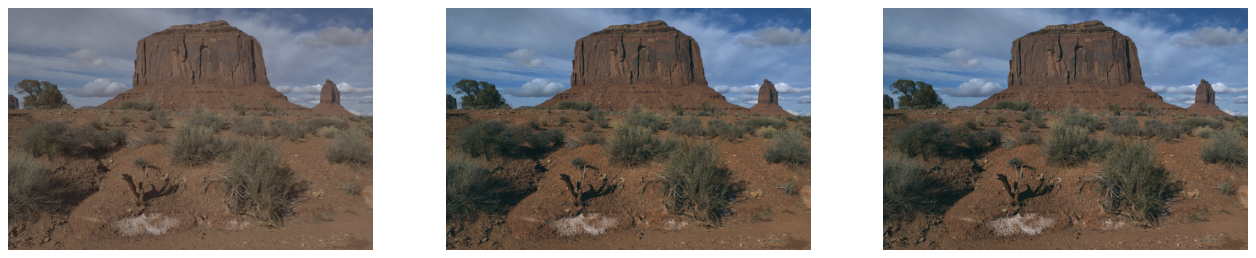

In [7]:
for test_sample, test_lut, test_style_vector in test_dataloader:
    
    test_sample       = test_sample[0]
    test_lut          = test_lut[0]
    test_style_vector = test_style_vector[0]
    
    test_sample_gpu = test_sample.cuda()
    
    with torch.no_grad():
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            ts_lut_out, _ = lut_model(test_sample_gpu)
            
    test_style_vector = test_style_vector.numpy()
    original_inp = test_sample[:,:3].view(tsimgsize[0],tsimgsize[1],3).numpy().astype(np.float32)
    np_out       = ts_lut_out.cpu().view(tsimgsize[0],tsimgsize[1],3).detach().numpy().astype(np.float32)
    np_gt        = test_lut.cpu().view(tsimgsize[0],tsimgsize[1],3).detach().numpy().astype(np.float32)
    np_diff      = ((np_gt - np_out)**2)

    assert (original_inp.max() <= 1) and (np_out.max() <= 1) and (np_gt.max() <= 1)
    psnr  = np_psnr(np_gt, np_out)
    
    deltae = deltae_dist(np_gt, np_out)
    
    print(f"STYLE {test_style_vector} PSNR={psnr}, DeltaE={deltae} --- shape {np_gt.shape}, min error {np.min(np_diff)}, max error {np.max(np_diff)}")
    plot_all([original_inp, np_gt, np_out], figsize=(20,10))

As you can see, **our single NILUT model encodes three different 3D LUTs**, and we can apply any learned style with high-precision. 

We also show the potential of **implicit style blending**. This interpolation happens inplicitely at the neural network, and the results are identical to the explicit images blending.

Note that this are unseen images! The model never saw these test images.

<br>
<img src="media/cnilut.png" alt="NILUT" width="1000"> 
<br>

Hope you like it 🤗 If you find this interesting/insightful/inspirational or you use it, do not forget to acknowledge our work:

```
@article{conde2023nilut,
  title={NILUT: Conditional Neural Implicit 3D Lookup Tables for Image Enhancement},
  author={Conde, Marcos V and Vazquez-Corral, Javier and Brown, Michael S and Timofte, Radu},
  journal={arXiv preprint arXiv:2306.11920},
  year={2023}
}
```
